In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [2]:
import sys
sys.path.append(r'F:\code\My GitHub\voice_based_ai_models\Models\research\audioset\yamnet')


In [3]:
import yamnet
import params
import special_params

In [33]:

params = special_params.Params()
params.num_classes = 521
yamnet_model = yamnet.yamnet_frames_model(params)


In [8]:
yamnet_model.summary()


Model: "yamnet_frames"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.compat.v1.shape_1 (TFOp  (1,)                         0         ['input_2[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.getitem_1  ()                           0         ['tf.compat.v1.shape_1[0][0]']
  (SlicingOpLambda)                                                                               
                                                                                      

In [9]:
# model: örneğin yamnet_model ya da feature_extractor olabilir

with open("yamnet_layers.txt", "w") as f:
    for i, layer in enumerate(yamnet_model.layers):
        f.write(f"{i}: {layer.name} - {layer.__class__.__name__} - {layer.output_shape}\n")

print("Tüm katmanlar 'yamnet_layers.txt' dosyasına yazıldı.")


Tüm katmanlar 'yamnet_layers.txt' dosyasına yazıldı.


In [34]:
tessst = yamnet_model(sick_audio_files[0])

In [35]:
tessst

[<tf.Tensor: shape=(2, 521), dtype=float32, numpy=
 array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
 array([[5.9133623e-20, 8.0832173e-20, 9.4315715e-21, ..., 4.5528073e-21,
         6.8380412e-21, 6.4609543e-21],
        [1.9076360e-19, 2.0602628e-19, 1.3075991e-20, ..., 2.0878515e-20,
         6.2836081e-21, 1.3356273e-20]], dtype=float32)>,
 <tf.Tensor: shape=(144, 64), dtype=float32, numpy=
 array([[-1.048633 , -1.4141245, -2.4498959, ..., -1.7570944, -1.505228 ,
         -1.4683931],
        [-0.9135425, -1.5830814, -2.2701979, ..., -1.6798733, -1.4297811,
         -1.7120833],
        [-0.894205 , -1.092468 , -1.5921221, ..., -1.4066528, -1.426339 ,
         -1.3806505],
        ...,
        [-6.9077554, -6.9077554, -6.9077554, ..., -6.9077554, -6.9077554,
         -6.9077554],
        [-6.9077554, -6.9077554, -6.9077554, ..., -6.9077554, -6.9077554,
         -6.9077554]

In [10]:
def load_audio_from_directory(directory_path, num_files=None, max_len=16000):
    audio_files = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)

            # Uzunluğu sabitle (padding veya truncate)
            if len(waveform) < max_len:
                waveform = np.pad(waveform, (0, max_len - len(waveform)), mode='constant')
            else:
                waveform = waveform[:max_len]

            audio_files.append(waveform)
    return audio_files






In [ ]:
how_many = 1000

sick_audio_files = load_audio_from_directory('../../data/data/Sick', how_many)
healthy_audio_files = load_audio_from_directory('../../data/data/Healthy', how_many)
none_audio_files = load_audio_from_directory('../../data/data/None', how_many)

In [ ]:
# Extract embeddings from each class
def get_embeddings_from_each_class(num_samples=10):
    sick_embeddings = []
    healthy_embeddings = []
    none_embeddings = []
    
    # Process samples from each class
    for i in range(min(num_samples, len(sick_audio_files))):
        _, emb, _ = yamnet_model(sick_audio_files[i])
        sick_embeddings.append(tf.reduce_mean(emb, axis=0).numpy())
    
    for i in range(min(num_samples, len(healthy_audio_files))):
        _, emb, _ = yamnet_model(healthy_audio_files[i])
        healthy_embeddings.append(tf.reduce_mean(emb, axis=0).numpy())
    
    for i in range(min(num_samples, len(none_audio_files))):
        _, emb, _ = yamnet_model(none_audio_files[i])
        none_embeddings.append(tf.reduce_mean(emb, axis=0).numpy())
    
    # Visualize the embeddings with PCA
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    all_embeddings = np.vstack([sick_embeddings, healthy_embeddings, none_embeddings])
    labels = ['Sick'] * len(sick_embeddings) + ['Healthy'] * len(healthy_embeddings) + ['None'] * len(none_embeddings)
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(['Sick', 'Healthy', 'None']):
        mask = [l == label for l in labels]
        plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=label)
    
    plt.legend()
    plt.title('YAMNet Embeddings Visualization (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    
    return sick_embeddings, healthy_embeddings, none_embeddings

# Visualize the embeddings
sick_embeddings, healthy_embeddings, none_embeddings = get_embeddings_from_each_class(num_samples=100)

In [12]:
import numpy as np

# Etiketler: Sick → 1, Healthy → 0, None → 2
X = np.array(sick_audio_files + healthy_audio_files + none_audio_files, dtype=np.float32)
y = np.array(
    [1] * len(sick_audio_files) + 
    [0] * len(healthy_audio_files) + 
    [2] * len(none_audio_files), 
    dtype=np.int32
)

print("X shape:", X.shape)  # (örnek_sayısı, örnek_uzunluğu)
print("y shape:", y.shape)  # (örnek_sayısı,)


X shape: (300, 16000)
y shape: (300,)


In [ ]:
from sklearn.model_selection import train_test_split


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((240, 16000), (240,), (60, 16000), (60,))

In [27]:
yamnet_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
yamnet_model.fit(X_train, y_train, epochs=10, batch_size=32, 
                 validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "f:\code\My GitHub\voice_based_ai_models\.venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "f:\code\My GitHub\voice_based_ai_models\.venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\code\My GitHub\voice_based_ai_models\.venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "f:\code\My GitHub\voice_based_ai_models\.venv\Lib\site-packages\tf_keras\src\engine\training.py", line 1147, in train_step
        y_pred = self(x, training=True)
    File "f:\code\My GitHub\voice_based_ai_models\.venv\Lib\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'tf.compat.v1.pad_1' (type TFOpLambda).
    
    Shape must be rank 1 but is rank 2 for '{{node yamnet_frames/tf.compat.v1.pad_1/Pad}} = Pad[T=DT_FLOAT, Tpaddings=DT_INT32](IteratorGetNext, yamnet_frames/tf.compat.v1.pad_1/Pad/paddings)' with input shapes: [32,16000], [1,2].
    
    Call arguments received by layer 'tf.compat.v1.pad_1' (type TFOpLambda):
      • tensor=tf.Tensor(shape=(32, 16000), dtype=float32)
      • paddings=[['0', 'tf.Tensor(shape=(), dtype=int32)']]
      • mode='CONSTANT'
      • name=None
      • constant_values=0.0


In [9]:
loss, accuracy = model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5777 - loss: 0.9212


In [10]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [11]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.5900


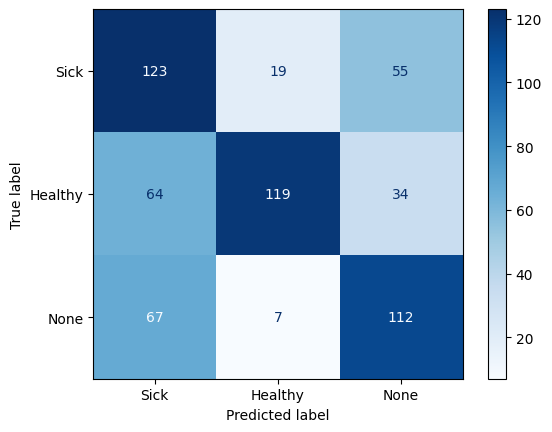

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')

In [13]:
from sklearn.metrics import classification_report
class_names = ["sick", "healthy", "none"]
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        sick       0.48      0.62      0.55       197
     healthy       0.82      0.55      0.66       217
        none       0.56      0.60      0.58       186

    accuracy                           0.59       600
   macro avg       0.62      0.59      0.59       600
weighted avg       0.63      0.59      0.60       600

